In [1]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import coint
import itertools

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pytz

import backtrader as bt
import statsmodels.api as sm

import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor
from utils import ModelBuilder
from utils import Predictor
pd.set_option('display.max_columns', None)

2023-12-13 00:01:56.920234: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 00:01:56.941199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

In [3]:
db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [4]:
df = db.DBtoDF("SELECT * FROM pairs_hourly")

/ibkr/databaseClass.py:113: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087505 entries, 0 to 1087504
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   date    1087505 non-null  datetime64[ns]
 1   ticker  1087505 non-null  object        
 2   open    1087505 non-null  float64       
 3   high    1087505 non-null  float64       
 4   low     1087505 non-null  float64       
 5   close   1087505 non-null  float64       
 6   volume  1087505 non-null  int64         
 7   count   1087505 non-null  int64         
 8   wap     1087505 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 74.7+ MB


In [6]:
# Filter criteria
criteria = (
    # Drop hours
    ~df['date'].dt.strftime('%H:%M:%S').isin(['04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00']) & 
    # Drop any value that has a 30 in it
    ~df['date'].dt.strftime('%H:%M:%S').str.contains('30') & 
    # Drop specific dates
    ~df['date'].dt.strftime('%Y-%m-%d').isin(['2023-08-21', '2023-06-20'])
)

# Apply the filter
df = df.loc[criteria]

In [7]:
df.set_index('date', inplace=True)
df = df.sort_index()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 988810 entries, 2023-06-21 09:00:00 to 2023-08-23 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ticker  988810 non-null  object 
 1   open    988810 non-null  float64
 2   high    988810 non-null  float64
 3   low     988810 non-null  float64
 4   close   988810 non-null  float64
 5   volume  988810 non-null  int64  
 6   count   988810 non-null  int64  
 7   wap     988810 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 67.9+ MB


In [9]:
cointegrated_pairs = [
 ('DCOM', 'NWBI', 6.931876734139303e-06),
 ('FRME', 'NWBI', 9.37938259373182e-05),
 ('TCMD', 'TPH', 0.00013073334263829345),
 ('CCS', 'LEN', 0.0006196557061908078),
 ('CAC', 'FRST', 0.0008485027070045955),
 ('LBAI', 'OCFC', 0.000903611374429789),
 ('CCS', 'MTH', 0.0009796528086234786),
 ('CAC', 'IBTX', 0.0010073871417657944),
 ('DCOM', 'SFST', 0.0011273781403298882),
 ('KBH', 'PHM', 0.0011802965098307982),
 ('NWBI', 'THFF', 0.0012415205030575284),
 ('FRST', 'IBTX', 0.001941843898475266),
 ('DCOM', 'FRME', 0.0022399937984697534),
 ('JOAN', 'MNTS', 0.002264131645384891),
 ('TMP', 'WSBC', 0.002372145409391496),
 ('NWBI', 'PPBI', 0.0024458720041988205),
 ('DCOM', 'RBB', 0.003658108066248698),
 ('MDC', 'PHM', 0.003958810756435488),
 ('FISI', 'IBTX', 0.0052866348855049065),
 ('MDC', 'MHO', 0.006825166993485608),
 ('LEN', 'TMHC', 0.008255969753706589),
 ('FFIC', 'FLIC', 0.008496965029977478),
 ('CIVB', 'MYFW', 0.00883506396397999),
 ('CNOB', 'FLIC', 0.009295107676352634),
 ('TCBK', 'WSBC', 0.009504000032407294),
 ('LILA', 'LILAK', 0.009563357266514647)
]

In [ ]:
db.dropTable("pairs_ticker_list")

In [ ]:
fieldList = '''(
    Ticker1 VARCHAR(20) NOT NULL,
    Ticker2 VARCHAR(20) NOT NULL
    )'''

db.buildTable("pairs_ticker_list", fieldList)

pairs = pd.DataFrame(cointegrated_pairs, columns=['Ticker1', 'Ticker2', 'Value3'])

# Drop the third column as we only need the first two
pairs = pairs.drop('Value3', axis=1)
db.DFtoDB(pairs, "pairs_ticker_list")

In [ ]:
pairs

In [10]:
new_list = []
for pair in cointegrated_pairs:
    new_list.append(pair[0])
    new_list.append(pair[1])

In [11]:
len(set(new_list))

35

In [12]:
# def process_pair(df, stock1, stock2, lookback=20, initial_investment=100000):
    
def process_pair(df, stock1, stock2, lookback, threshold, trade_percentage, max_multiplier, stop_loss_percentage, take_profit_percentage):
    # Filter for pairs data
    df_stock1 = df[df['ticker'] == stock1].copy()
    df_stock2 = df[df['ticker'] == stock2].copy()
    df_SPY = df[df['ticker'] == 'SPY'].copy()


    df_stock1 = df_stock1.add_suffix('_stock1')
    df_stock2 = df_stock2.add_suffix('_stock2')
    df_SPY = df_SPY.add_suffix('_SPY')
    df_combined = df_stock1.merge(df_stock2, left_index=True, right_index=True)

    df_combined['spread'] = df_combined['close_stock1'] - df_combined['close_stock2']

    # Calculate mean and std deviation
    df_combined['rolling_mean'] = df_combined['spread'].rolling(window=lookback).mean()
    df_combined['rolling_std'] = df_combined['spread'].rolling(window=lookback).std()

    # Decide Buy/Sell signals
    threshold = 1  # e.g., 1 std deviation
    df_combined['signal'] = 'Do Nothing'
    df_combined.loc[df_combined['spread'] > df_combined['rolling_mean'] + threshold * df_combined['rolling_std'], 'signal'] = 'Sell Stock1, Buy Stock2'
    df_combined.loc[df_combined['spread'] < df_combined['rolling_mean'] - threshold * df_combined['rolling_std'], 'signal'] = 'Buy Stock1, Sell Stock2'


    # Update portfolio calculations using df_combined
    initial_investment = 100000
    total_cash = initial_investment
    stock1_qty_cumulative = 0
    stock2_qty_cumulative = 0

    # Initialize portfolio and quantities columns
    df_combined['portfolio_value'] = np.nan
    df_combined['stock1_qty'] = np.nan
    df_combined['stock2_qty'] = np.nan
    df_combined['total_cash'] = np.nan
    df_combined['stock1_value'] = np.nan
    df_combined['stock2_value'] = np.nan
    df_combined['exit_reason'] = 'None'

    df_combined['z_score'] = (df_combined['spread'] - df_combined['rolling_mean']) / df_combined['rolling_std']

    # Keeping track of peak portfolio value for stop loss:
    peak_portfolio_value = initial_investment
    entry_portfolio_value = initial_investment


    for i, row in df_combined.iterrows():

        # Values for stocks based on current holdings:
        stock1_value = stock1_qty_cumulative * row['close_stock1']
        stock2_value = stock2_qty_cumulative * row['close_stock2']
        portfolio_value_before_trade = stock1_value + stock2_value + total_cash

        # Calculate adaptive trade size based on z-score
        base_trade_size = portfolio_value_before_trade * trade_percentage
        adaptive_trade_size = base_trade_size * min(abs(row['z_score']), max_multiplier)

        # Trading signals:
        if row['signal'] == 'Buy Stock1, Sell Stock2':
            stock1_qty = adaptive_trade_size / 2 / row['close_stock1']
            stock2_qty = -adaptive_trade_size / 2 / row['close_stock2']
        elif row['signal'] == 'Sell Stock1, Buy Stock2':
            stock1_qty = -adaptive_trade_size / 2 / row['close_stock1']
            stock2_qty = adaptive_trade_size / 2 / row['close_stock2']
        else:  # 'Do Nothing'
            stock1_qty = 0
            stock2_qty = 0

        # Stop-loss logic
        if portfolio_value_before_trade <= (1 - stop_loss_percentage) * peak_portfolio_value:
            df_combined.at[i, 'exit_reason'] = 'Stop-loss'
            total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
            stock1_qty_cumulative = 0
            stock2_qty_cumulative = 0
            peak_portfolio_value = total_cash
            df_combined.at[i, 'total_cash'] = total_cash
            df_combined.at[i, 'stock1_value'] = 0  # because all positions are closed
            df_combined.at[i, 'stock2_value'] = 0
            df_combined.at[i, 'portfolio_value'] = total_cash
            df_combined.at[i, 'stock1_qty'] = 0
            df_combined.at[i, 'stock2_qty'] = 0
            continue

        # Take-profit logic
        elif i != 0 and portfolio_value_before_trade >= (1 + take_profit_percentage) * entry_portfolio_value:
            df_combined.at[i, 'exit_reason'] = 'take-profit'
            total_cash += stock1_qty_cumulative * row['close_stock1'] + stock2_qty_cumulative * row['close_stock2']
            stock1_qty_cumulative = 0
            stock2_qty_cumulative = 0
            entry_portfolio_value = total_cash
            df_combined.at[i, 'total_cash'] = total_cash
            df_combined.at[i, 'stock1_value'] = 0  # because all positions are closed
            df_combined.at[i, 'stock2_value'] = 0
            df_combined.at[i, 'portfolio_value'] = total_cash
            df_combined.at[i, 'stock1_qty'] = 0
            df_combined.at[i, 'stock2_qty'] = 0

            continue

        # If neither stop-loss nor take-profit conditions are met, execute the trade based on the signal
        cash_spent_on_stock1 = stock1_qty * row['close_stock1']
        cash_spent_on_stock2 = stock2_qty * row['close_stock2']
        total_cash -= cash_spent_on_stock1 + cash_spent_on_stock2
        stock1_qty_cumulative += stock1_qty
        stock2_qty_cumulative += stock2_qty

        # Update portfolio value after the trade:
        stock1_value = stock1_qty_cumulative * row['close_stock1']
        stock2_value = stock2_qty_cumulative * row['close_stock2']
        portfolio_value = stock1_value + stock2_value + total_cash

        # Update the peak portfolio value if the current value is greater
        peak_portfolio_value = max(peak_portfolio_value, portfolio_value)

        df_combined.at[i, 'total_cash'] = total_cash
        df_combined.at[i, 'stock1_value'] = stock1_value
        df_combined.at[i, 'stock2_value'] = stock2_value
        df_combined.at[i, 'portfolio_value'] = portfolio_value
        df_combined.at[i, 'stock1_qty'] = stock1_qty_cumulative
        df_combined.at[i, 'stock2_qty'] = stock2_qty_cumulative


    # 2. Calculate SPY Portfolio Value:
    df_combined = df_combined.join(df_SPY, how='left')
    # initial_investment = df_combined['portfolio_value'].iloc[0]
    df_combined['SPY_returns'] = df_combined['close_SPY'].pct_change().fillna(0)
    df_combined['SPY_cumulative_returns'] = (1 + df_combined['SPY_returns']).cumprod()
    df_combined['SPY_portfolio_value'] = df_combined['SPY_cumulative_returns'] * initial_investment
    return df_combined

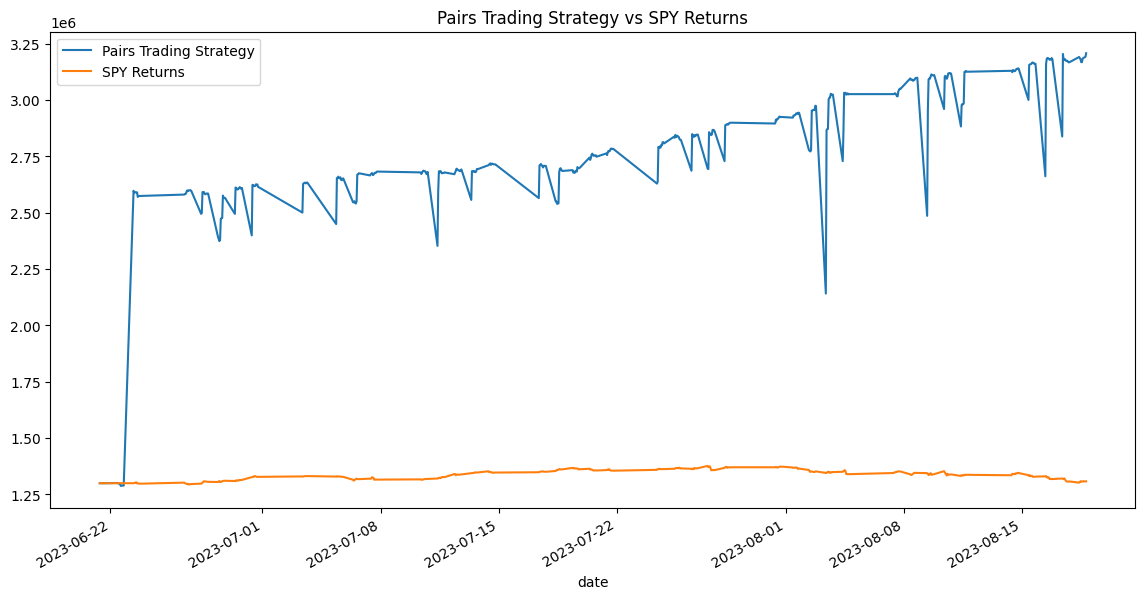

{'Alpha': 0.0032223790085533516,
 'Beta': -0.14664912748604975,
 'Sharpe Ratio': 24.91639180059189,
 'Total Return': 1.467736893030595,
 'Final_portfolio_value': 3208057.9609397734,
 'Initial Investment': 1300000.0}

In [13]:
# this is to run one time. 
dfs = []  # List to store individual pair dataframes

for pair in cointegrated_pairs:
    stock1, stock2, _ = pair
    
    df_combined = process_pair(df, stock1, stock2, lookback=10, threshold=1.5, trade_percentage=.6, max_multiplier = 2.5, stop_loss_percentage=0.04, take_profit_percentage = 0.05)
    df_combined['pair'] = f"{stock1}-{stock2}"  # Add an additional column to identify the pair
    dfs.append(df_combined)

master_df = pd.concat(dfs)

output_df = master_df.groupby(master_df.index).agg({
    'portfolio_value': 'sum',
    'total_cash': 'sum',
    'SPY_returns': 'first'
})

initial_investment = output_df['portfolio_value'].iloc[0]
output_df['SPY_cumulative_returns'] = (1 + output_df['SPY_returns']).cumprod()
output_df['SPY_portfolio_value'] = initial_investment * output_df['SPY_cumulative_returns']

def evaluate_aggregated_df(df):
    #expected that df is the output_df
    # Total return
    final_portfolio_value = df['portfolio_value'].iloc[-1]
    initial_investment = df['portfolio_value'].iloc[0]
    total_return = (final_portfolio_value - initial_investment) / initial_investment

    # Prepare data for regression
    X = df['SPY_returns']
    X = sm.add_constant(X)  # Adds a constant (intercept) to the model
    y = df['portfolio_value'].pct_change().fillna(0)

    # Regression model
    model = sm.OLS(y, X).fit()

    alpha = model.params[0]
    beta = model.params[1]
    
    # 5. Calculate Sharpe Ratio:
    risk_free_rate = 0.02  # Approximated risk-free rate, adjust as needed
    strategy_excess_return = total_return - risk_free_rate
    strategy_std = df['portfolio_value'].pct_change().fillna(0).std()
    sharpe_ratio = strategy_excess_return / strategy_std


    
    return {
        "Alpha": alpha,
        "Beta": beta,
        "Sharpe Ratio": sharpe_ratio,
        "Total Return": total_return,
        "Final_portfolio_value": final_portfolio_value,
        "Initial Investment": initial_investment
    }

def plot_aggregated(df):
    plt.figure(figsize=(14,7))
    df['portfolio_value'].plot(label='Pairs Trading Strategy')
    df['SPY_portfolio_value'].plot(label='SPY Returns')
    plt.legend()
    plt.title('Pairs Trading Strategy vs SPY Returns')
    plt.show()
    
plot_aggregated(output_df)
evaluate_aggregated_df(output_df)

In [14]:
# Grid Search

from itertools import product

# Define your parameter grid.
param_grid = {
    'lookback': [10, 20, 30, 40],
    'threshold': [0.5, 1, 1.5],
    'trade_percentage': [0.40, 0.50, 0.60],
    'max_multiplier': [1.5, 2.0, 2.5],
    'stop_loss_percentage': [0.02, 0.03, 0.04],
    'take_profit_percentage': [0.04, 0.05, 0.06]
}

all_names = sorted(param_grid)
combinations = product(*(param_grid[name] for name in all_names))
column_order = ["Alpha", "Beta", "Sharpe Ratio", "Total Return"] + all_names
df_results = pd.DataFrame(columns=column_order)

# Grid search loop
for values in combinations:
    params = dict(zip(all_names, values))

    dfs = []
    for pair in cointegrated_pairs:
        stock1, stock2, _ = pair
        df_combined = process_pair(df, stock1, stock2, **params)
        df_combined['pair'] = f"{stock1}-{stock2}"
        dfs.append(df_combined)

    master_df = pd.concat(dfs)
    output_df = master_df.groupby(master_df.index).agg({
        'portfolio_value': 'sum',
        'total_cash': 'sum',
        'SPY_returns': 'first'
    })

    initial_investment = output_df['portfolio_value'].iloc[0]
    output_df['SPY_cumulative_returns'] = (1 + output_df['SPY_returns']).cumprod()
    output_df['SPY_portfolio_value'] = initial_investment * output_df['SPY_cumulative_returns']

    performance = evaluate_aggregated_df(output_df)
    
    # Store results
    for param_name, param_value in params.items():
        performance[param_name] = param_value

    df_results.loc[len(df_results)] = performance  # Add performance to the results dataframe

# Sort by alpha for easier review
df_results = df_results.sort_values(by="Alpha", ascending=False).reset_index(drop=True)

In [ ]:
# Below is for real time, 5 second bars. 

In [15]:
def get_data_for_real_time(n):
    '''
    n is the number of rows to include for each ticker.  each row represents 5 seconds of aggregated data
    '''
    
    query = f'''
                SELECT * FROM (
                    SELECT *, ROW_NUMBER() OVER (PARTITION BY ticker ORDER BY date DESC) as rn
                    FROM pairs_live_trading
                ) t
                WHERE t.rn <= {n}
                '''.format(n)

    df = db.DBtoDF(query)
    
    dates = df['date'].drop_duplicates().to_list()
    pairs = db.DBtoDF('SELECT * FROM pairs_ticker_list')
    
    #expanding the pairs for each ticker pair and each timeframe
    expanded_pairs = pairs.loc[np.repeat(pairs.index.values, len(dates))]
    expanded_pairs['Date'] = np.tile(dates, len(pairs))
    expanded_pairs = expanded_pairs.rename(columns={'ticker1': 'Ticker1',
                                                    'ticker2': 'Ticker2'})

    merged = pd.merge(expanded_pairs, df, left_on=['Ticker1', 'Date'], right_on=['ticker', 'date'], how='left')
    merged = merged.rename(columns={
                                'open': 'open_ticker1',
                                'high': 'high_ticker1',
                                'low': 'low_ticker1',
                                'close': 'close_ticker1',
                                'volume': 'volume_ticker1',
                                'count': 'count_ticker1',
                                'wap': 'wap_ticker1',
                                'rn': 'rn_ticker1',

                            })

    merged = pd.merge(merged, df, left_on=['Ticker2', 'Date'], right_on=['ticker', 'date'], how='left')
    merged = merged.rename(columns={
                                'open': 'open_ticker2',
                                'high': 'high_ticker2',
                                'low': 'low_ticker2',
                                'close': 'close_ticker2',
                                'volume': 'volume_ticker2',
                                'count': 'count_ticker2',
                                'wap': 'wap_ticker2',
                                'rn': 'rn_ticker2',

                            })
    merged = merged.drop(['date_x', 'ticker_x', 'date_y', 'ticker_y'], axis=1)
    merged['open_ratio'] = merged['open_ticker1'] / merged['open_ticker2']
    merged['high_ratio'] = merged['high_ticker1'] / merged['high_ticker2']
    merged['low_ratio'] = merged['low_ticker1'] / merged['low_ticker2']
    merged['wap_ratio'] = merged['wap_ticker1'] / merged['wap_ticker2']
    columns_to_aggregate = [col for col in merged.columns if col not in ['Ticker1', 'Ticker2', 'Date']]
    aggregation_functions = {col: ['mean', 'std'] for col in columns_to_aggregate}
    aggregated_df = merged.groupby(['Ticker1', 'Ticker2']).agg(aggregation_functions)
    aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]
    aggregated_df.reset_index(inplace=True)
    return aggregated_df

In [16]:
start_time = time.time()

get_data_for_real_time(5)
print("My program took", time.time() - start_time, "to run")


My program took 0.020337820053100586 to run


/ibkr/databaseClass.py:113: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)
/ibkr/databaseClass.py:113: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [ ]:
get_data_for_real_time(15)